In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from helper_functions import *
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Import train data

In [27]:
train = pd.read_csv('train.csv')
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [28]:
HORIZON = 8
WINDOW_SIZE = 8

IDS = train.cfips.unique()

## Process:
* set the size of train and test data -> test data as last 8 period. 
* Train the data, then get the result. 
    * Store the country number, MAPE, last density value, and last active size to analyze the result later. 
    * Pick random country
    * Create train_window and labels. 
    * Split train and test data. 
    * Create model, compile then fit. 
    * Get the results. 
    * Plot the result. 
* Create DataFrame. 

{'mae': 0.016890079, 'mse': 0.00035930565, 'rmse': 0.01895536, 'mape': 0.8137746}


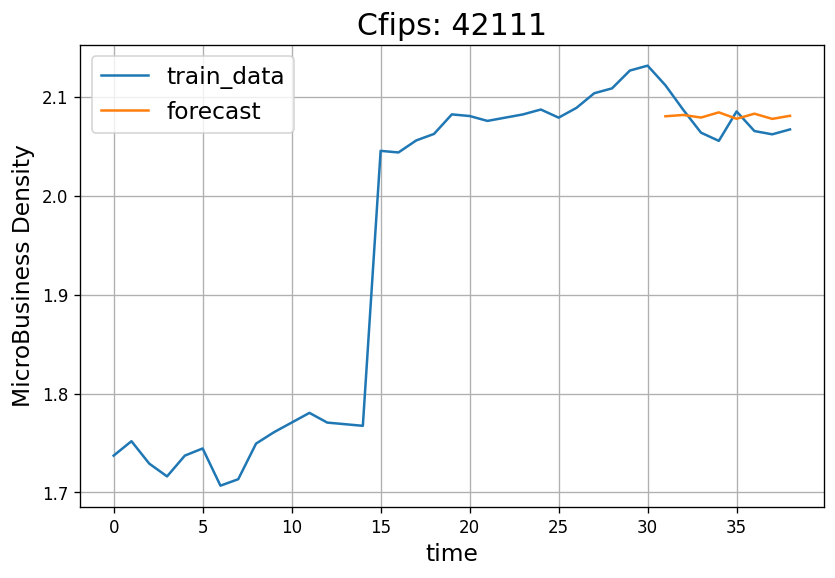








{'mae': 0.03535877, 'mse': 0.0012509342, 'rmse': 0.035368547, 'mape': 35.3352}


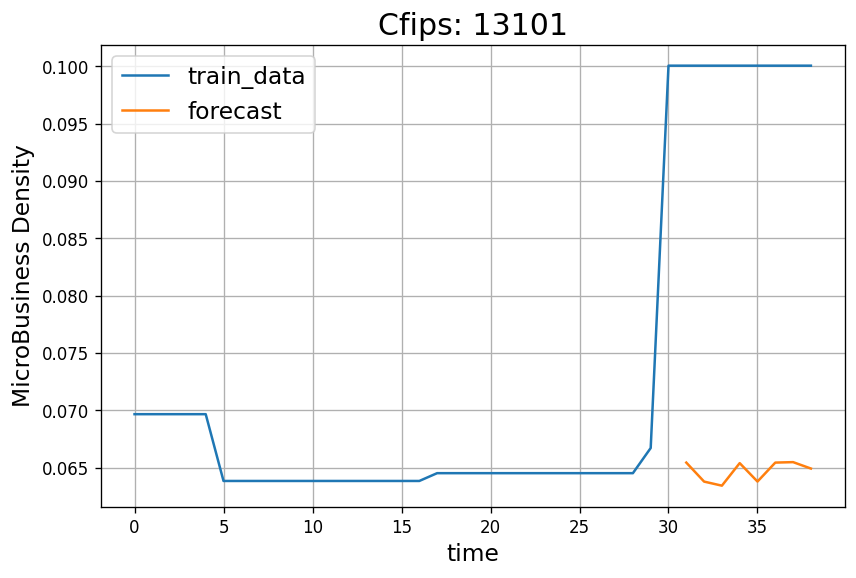








{'mae': 0.20412552, 'mse': 0.05967192, 'rmse': 0.24427836, 'mape': 4.3848305}


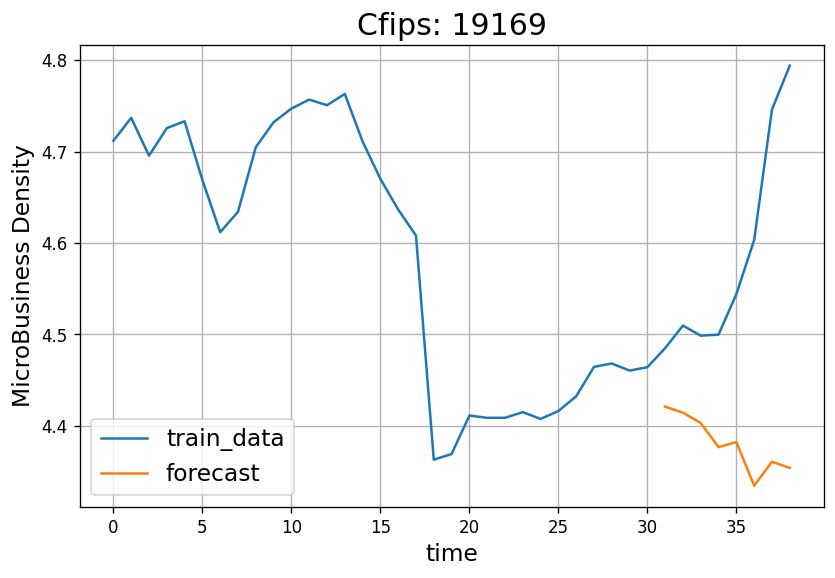








{'mae': 0.18578845, 'mse': 0.050072454, 'rmse': 0.22376874, 'mape': 4.76586}


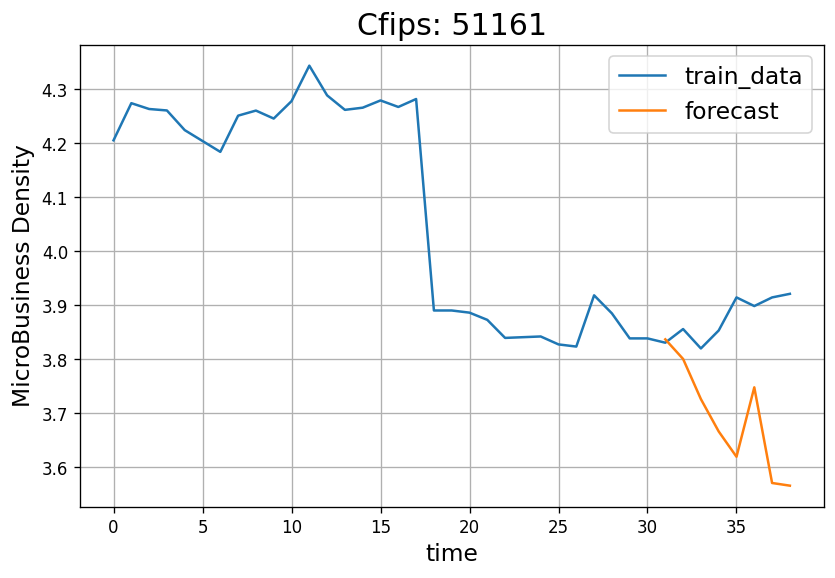








{'mae': 0.041340426, 'mse': 0.0021385609, 'rmse': 0.046244577, 'mape': 2.0418692}


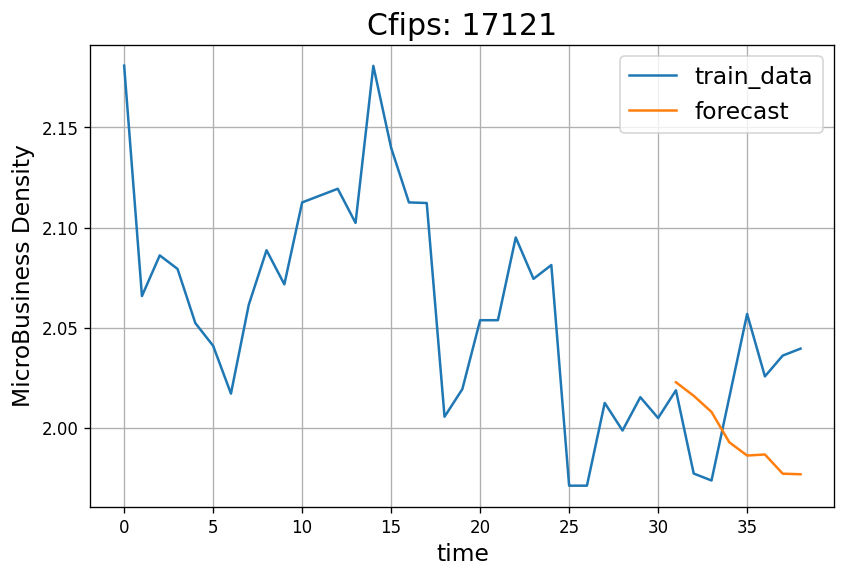








CPU times: total: 4.25 s
Wall time: 12.3 s


In [48]:
%%time

x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(31,39).reshape((-1,1))

forecasts = []
cfips_list = []
mapes = []
density_values = []
active_size = []

for i in range(5):
    c = np.random.choice(IDS)
    cfips_list.append(c)
    df = train.loc[train.cfips==c]
    last_density = df.microbusiness_density.values[-1]
    density_values.append(last_density)
    last_active = df.active.values[-1]
    active_size.append(last_active)
    
    # Create train dataset
    windows, labels = make_windows(df.microbusiness_density.values, window_size=WINDOW_SIZE, horizon=HORIZON)
    
    # Split trin and test set
    train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows, labels)
    
    # tensorflow model, compile, fit
    tf.random.set_seed(42)

    model = tf.keras.Sequential([
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(HORIZON)
    ], name='lstm_model')

    model.compile(loss='mae', 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['mae', 'mse'])

    model.fit(x=train_windows, 
             y=train_labels, 
             epochs=500,
             batch_size=256, verbose=0)
    
    # Predict test data
    preds = make_preds(model, test_windows)
    forecasts.append(preds)
        
    # Evaluate 
    results = evaluate_preds(test_labels, preds)
    mape = results['mape']
    mapes.append(mape)
    print(results)
     
    # PLOT STUFF
    plot_time_series(c, x_train, df.microbusiness_density.values, label='train_data')
    plot_time_series(c, x_test, preds, label='forecast')
    plt.show()
    print('\n\n\n\n\n\n')

In [49]:
result_df = pd.DataFrame({'Country': cfips_list, 
                         'MAPE': mapes, 
                         'Last density': density_values,
                         'Last Active': active_size})
result_df

,Country,MAPE,Last density,Last Active
0,42111,0.813775,2.067243,1250
1,13101,35.335201,0.100067,3
2,19169,4.384830,4.793889,3897
3,51161,4.765860,3.921438,2947
4,17121,2.041869,2.039615,589


### Create the random sample to begin. 

Same process but not plotting. Create 100 samples 

In [50]:
%%time
sample_size = 100
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(31,39).reshape((-1,1))

forecasts = []
cfips_list = []
mapes = []
density_values = []
active_size = []

for i in range(sample_size):
    c = np.random.choice(IDS)
    cfips_list.append(c)
    df = train.loc[train.cfips==c]
    last_density = df.microbusiness_density.values[-1]
    density_values.append(last_density)
    last_active = df.active.values[-1]
    active_size.append(last_active)
    
    # Create train dataset
    windows, labels = make_windows(df.microbusiness_density.values, window_size=WINDOW_SIZE, horizon=HORIZON)
    
    # Split trin and test set
    train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows, labels)
    
    # tensorflow model, compile, fit
    tf.random.set_seed(42)

    model = tf.keras.Sequential([
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(HORIZON)
    ], name='dence_model')

    model.compile(loss='mae', 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['mae', 'mse'])

    model.fit(x=train_windows, 
             y=train_labels, 
             epochs=500,
             batch_size=256, verbose=0)
    
    # Predict test data
    preds = make_preds(model, test_windows)
    forecasts.append(preds)
        
    # Evaluate 
    results = evaluate_preds(test_labels, preds)
    mape = results['mape']
    mapes.append(mape)
    #print(results)

# create DataFrame
result_df = pd.DataFrame({'Country': cfips_list, 
                         'MAPE': mapes, 
                         'Last density': density_values,
                         'Last Active': active_size, 
                         'forecast': forecast})

CPU times: total: 1min 10s
Wall time: 3min 52s


In [73]:
result_df.head()

,Country,MAPE,Last density,Last Active,forecast
0,19187,17.895084,2.765460,792,"(tf.Tensor(2.0703213, shape=(), dtype=float32)..."
1,27039,5.235615,2.506184,385,"(tf.Tensor(2.3430963, shape=(), dtype=float32)..."
2,19099,4.077245,3.302771,951,"(tf.Tensor(3.7589235, shape=(), dtype=float32)..."
3,48111,7.570204,3.032153,149,"(tf.Tensor(2.6554449, shape=(), dtype=float32)..."
4,13173,12.764166,0.953895,78,"(tf.Tensor(0.78984356, shape=(), dtype=float32..."


## Plot randomly

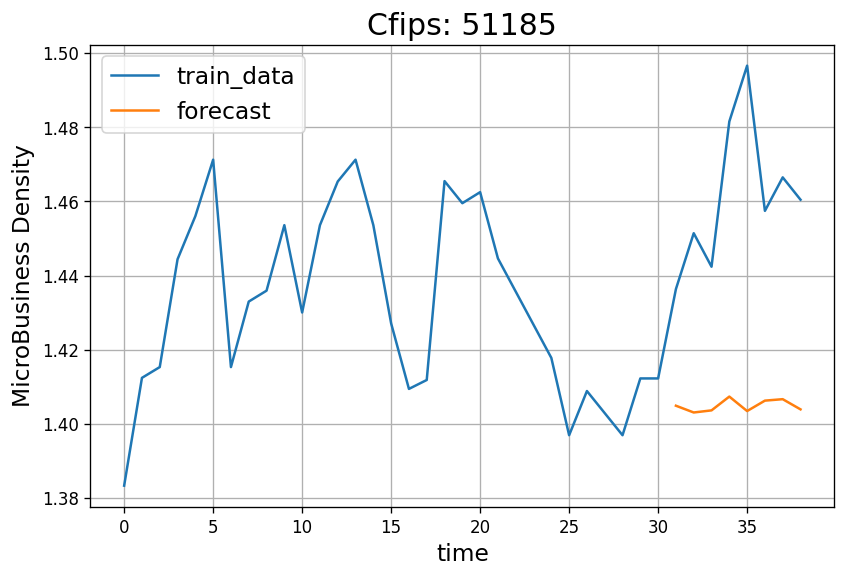

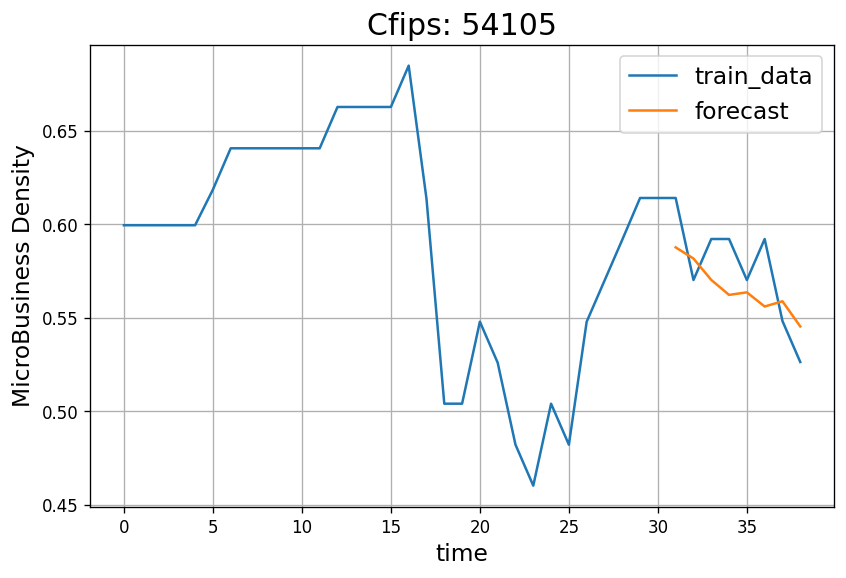

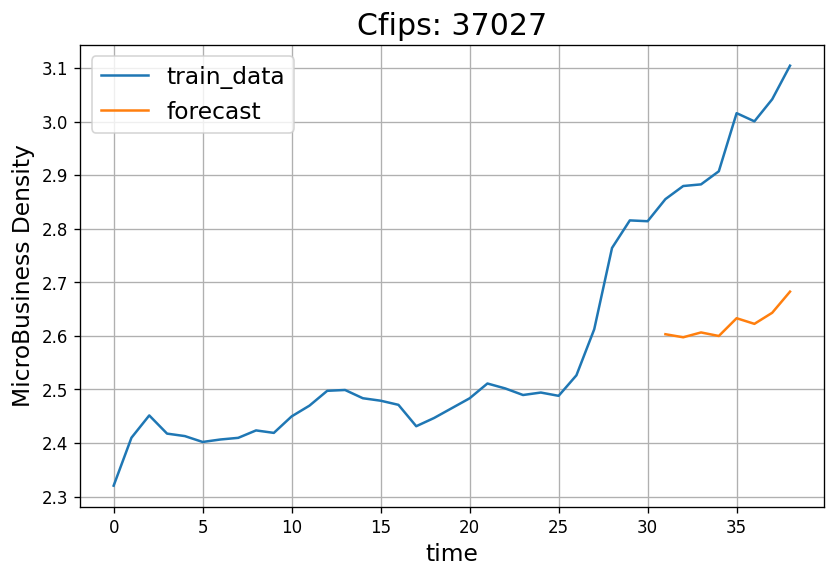

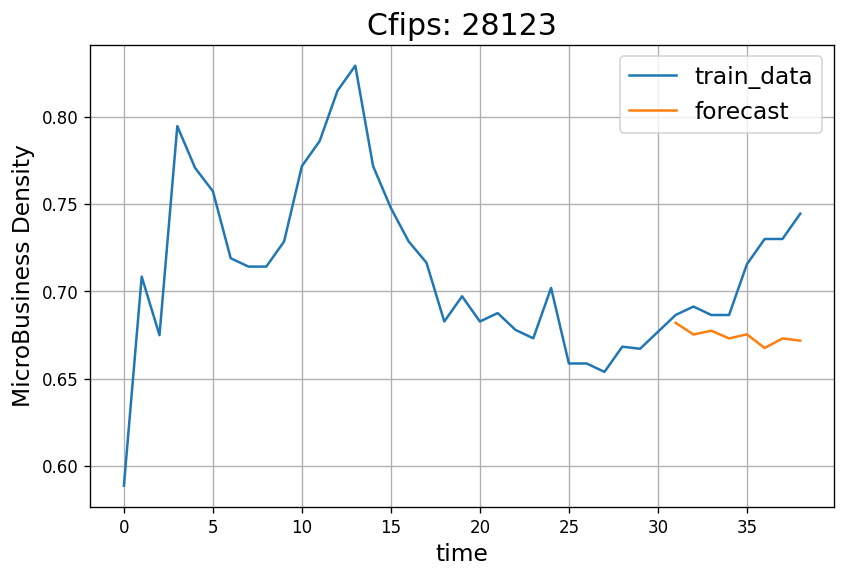

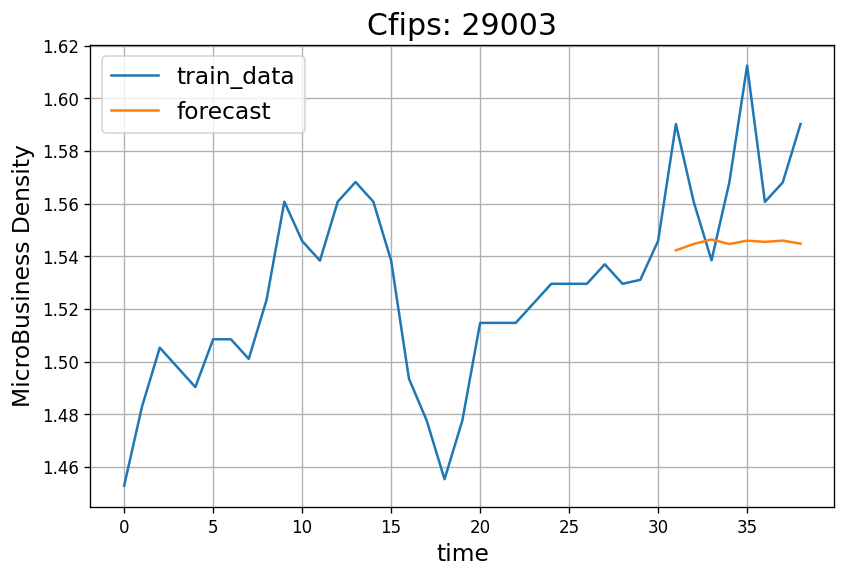

In [72]:
result_df['forecast'] = forecasts
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(31,39).reshape((-1,1))

for idx in random.sample(list(result_df.index), 5):
    c = result_df.loc[idx].Country
    df = train[train.cfips == c]
    preds = result_df.loc[idx].forecast
    plot_time_series(c, x_train, df.microbusiness_density.values, label='train_data')
    plot_time_series(c, x_test, preds, label='forecast')
    plt.show()

In [75]:
# save the result dataframe
result_df.to_csv('100_sample_results_dence.csv', index=False)

## load result df then analyze the result

In [76]:
# load the result df
df = pd.read_csv('100_sample_results_dence.csv')
df.head()

,Country,MAPE,Last density,Last Active,forecast
0,19187,17.895084,2.765460,792,tf.Tensor(\n[2.0703213 2.0597637 2.0725462 2.0...
1,27039,5.235615,2.506184,385,tf.Tensor(\n[2.3430963 2.3485742 2.3508792 2.3...
2,19099,4.077245,3.302771,951,tf.Tensor(\n[3.7589235 3.723605 3.6697953 3.5...
3,48111,7.570204,3.032153,149,tf.Tensor(\n[2.6554449 2.6697195 2.7031105 2.7...
4,13173,12.764166,0.953895,78,tf.Tensor(\n[0.78984356 0.79417497 0.79507715 ...


In [77]:
# correlation
df.corr()

,Country,MAPE,Last density,Last Active
Country,1.000000,-0.137529,0.032278,0.158459
MAPE,-0.137529,1.000000,-0.167791,-0.027228
Last density,0.032278,-0.167791,1.000000,0.751210
Last Active,0.158459,-0.027228,0.751210,1.000000


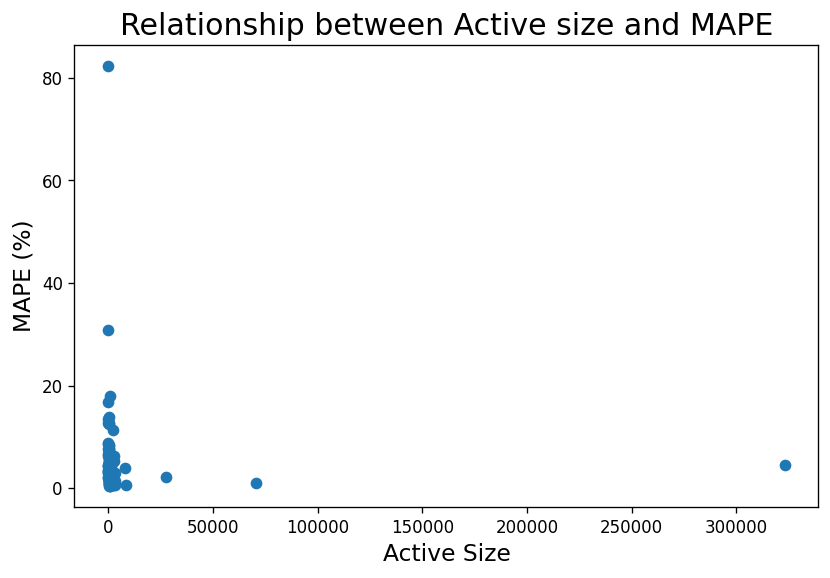

In [78]:
plt.scatter(x=df['Last Active'], y=df['MAPE'])
plt.title('Relationship between Active size and MAPE', fontsize=18)
plt.xlabel('Active Size', fontsize=14)
plt.ylabel('MAPE (%)', fontsize=14)
plt.show()

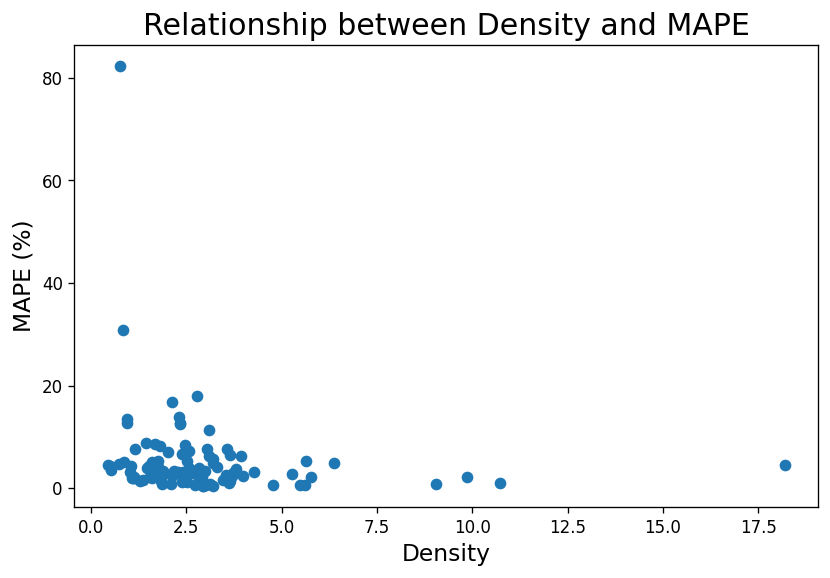

In [79]:
plt.scatter(x=df['Last density'], y=df['MAPE'])
plt.title('Relationship between Density and MAPE', fontsize=18)
plt.xlabel('Density', fontsize=14)
plt.ylabel('MAPE (%)', fontsize=14)
plt.show()

In [80]:
df.describe()

,Country,MAPE,Last density,Last Active
count,100.000000,100.000000,100.000000,100.000000
mean,29034.750000,5.292893,2.878816,5060.810000
std,14572.853809,8.976836,2.348449,32995.519267
min,1001.000000,0.479297,0.451977,3.000000
25%,18110.500000,1.915354,1.616230,147.000000
50%,29138.000000,3.237606,2.446671,436.000000
75%,41303.000000,5.270968,3.195278,1103.250000
max,55051.000000,82.349120,18.188141,322989.000000


In [81]:
# Categorize by MAPE
df['Category'] = pd.cut(df['MAPE'], bins=[0, 1.2, 2.5, 3.8, max(df['MAPE'])], labels=[1, 2, 3, 4])

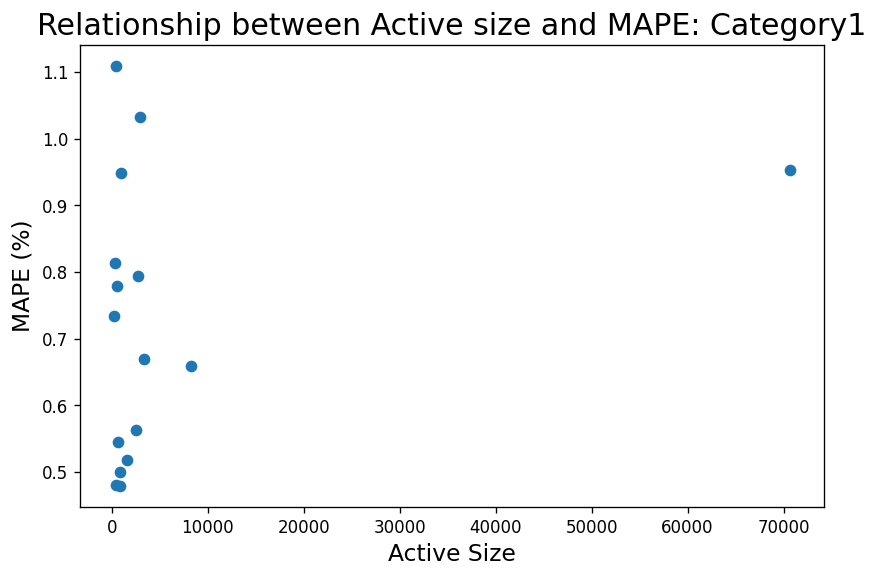

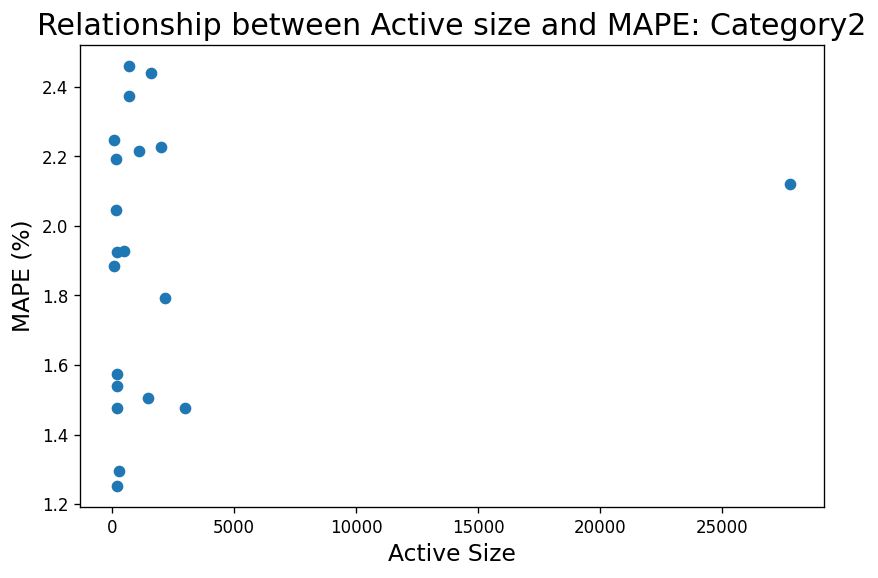

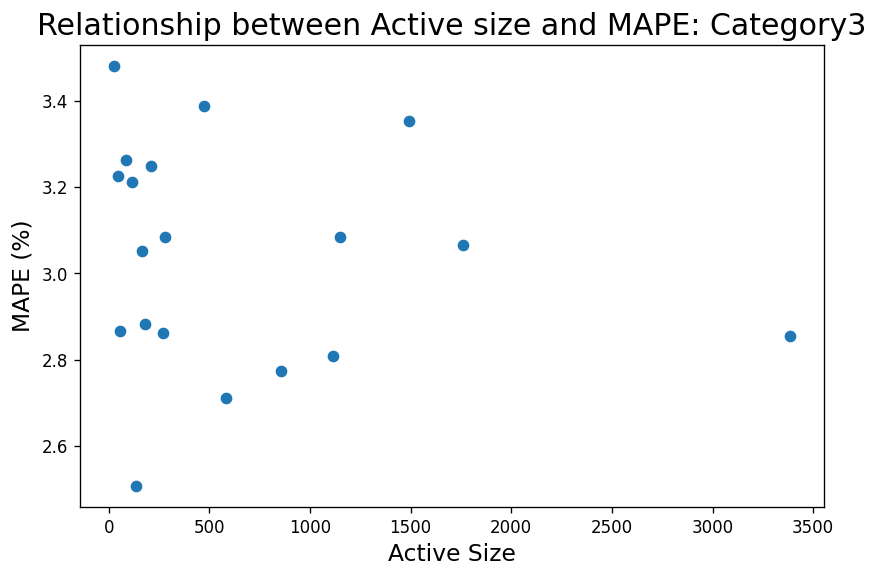

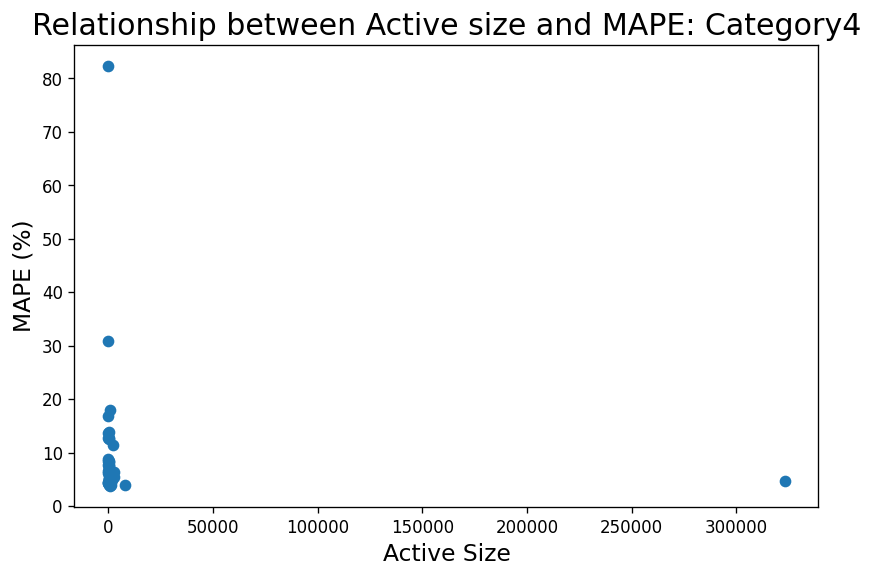

In [82]:
category_group = df.groupby(by='Category')
for name, group in category_group:
    plt.scatter(x=group['Last Active'], y=group['MAPE'])
    plt.title(f'Relationship between Active size and MAPE: Category{name}', fontsize=18)
    plt.xlabel('Active Size', fontsize=14)
    plt.ylabel('MAPE (%)', fontsize=14)
    plt.show()

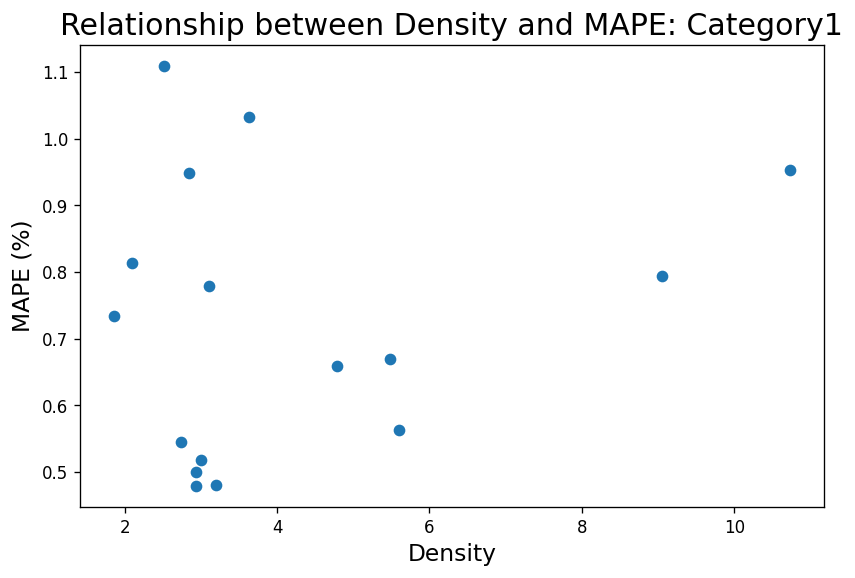

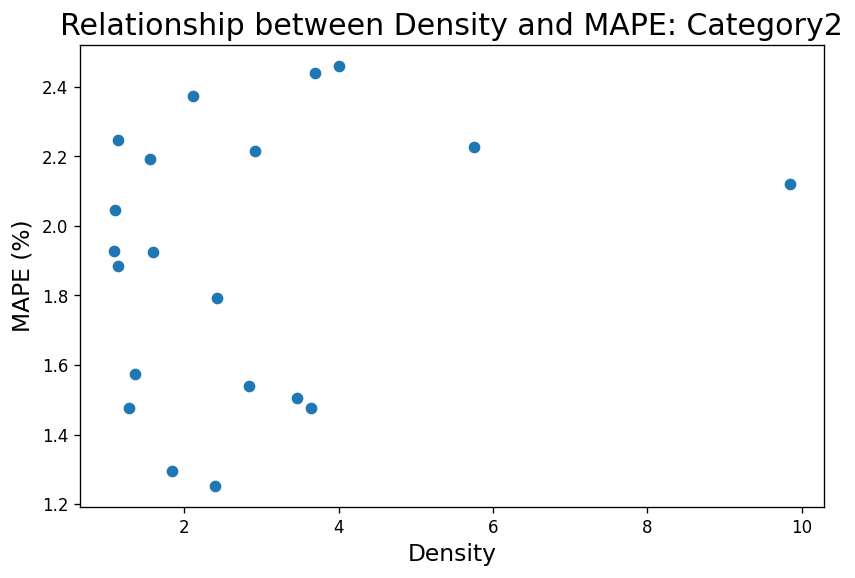

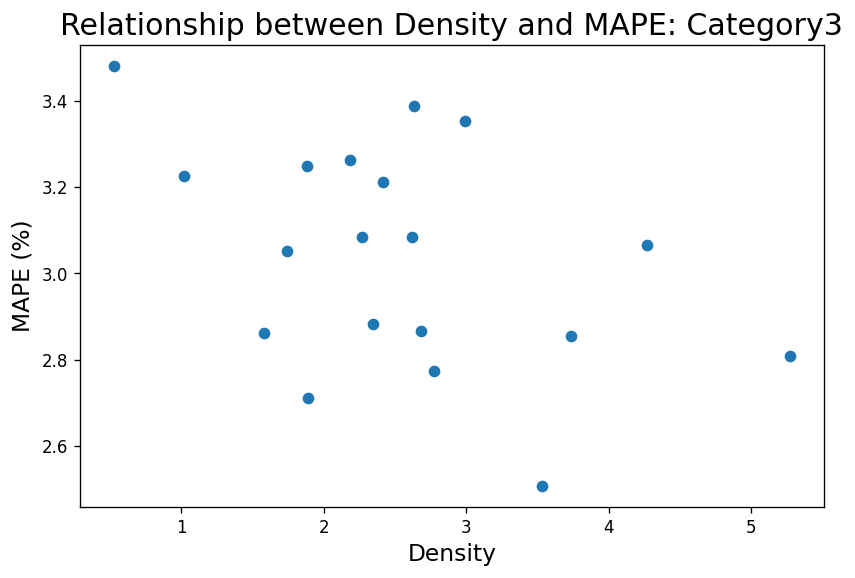

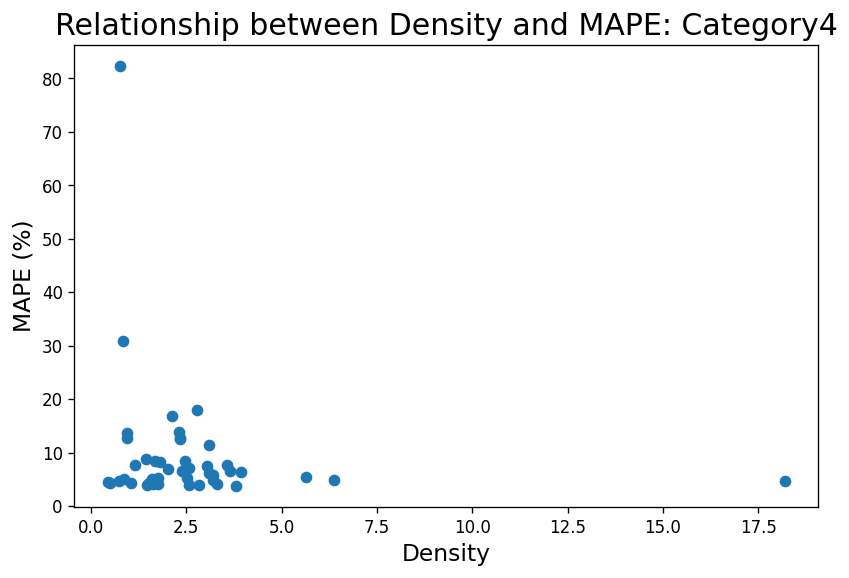

In [83]:
for name, group in category_group:
    plt.scatter(x=group['Last density'], y=group['MAPE'])
    plt.title(f'Relationship between Density and MAPE: Category{name}', fontsize=18)
    plt.xlabel('Density', fontsize=14)
    plt.ylabel('MAPE (%)', fontsize=14)
    plt.show()

In [84]:
for name, group in category_group:
    print(f'Category: {name}\nData Size: {len(group)}')
    print(f'Correlation matrix: \n{group.corr()}\n')
    print(group.describe())

Category: 1
Data Size: 16
Correlation matrix: 
               Country      MAPE  Last density  Last Active
Country       1.000000  0.120108     -0.093323     0.172191
MAPE          0.120108  1.000000      0.185255     0.291580
Last density -0.093323  0.185255      1.000000     0.738712
Last Active   0.172191  0.291580      0.738712     1.000000

            Country       MAPE  Last density   Last Active
count     16.000000  16.000000     16.000000     16.000000
mean   28882.187500   0.723712      4.156848   6085.375000
std    13110.863583   0.206549      2.503686  17343.006609
min     1101.000000   0.479297      1.854959    199.000000
25%    22780.500000   0.538433      2.812686    508.000000
50%    27638.000000   0.702241      3.056472    866.000000
75%    33626.000000   0.847823      4.958773   2786.500000
max    51670.000000   1.109603     10.732252  70678.000000
Category: 2
Data Size: 20
Correlation matrix: 
               Country      MAPE  Last density  Last Active
Country       

## Conclusion

There are no correlation with MAPE and other values. I will simply train differently by the results to maximize MAPE for each category. 

Before doing it, I will get rsult from entire dataset, then check the correlation with it. 